Sampling for CellApp Training
========================

Below is a quick bit of code that was used to select a set of experiments and regions for the labeling effort. The charges were to: sample in depth; make sure a representative set of "problem experiments" (listed below) make it in the sample; make sure a set of 3P exeriments are also sampled (exeriments starting with 8).

The sampling chosen was to sample uniformly for each unique value of depth and sample experiments without replacement.

In [1]:
import h5py
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

Load experiment metadata.

In [2]:
json_data = json.load(open('/allen/programs/mindscope/workgroups/surround/'
                           'select_validation/ssf_metadata.json'))

Load data for experiment id, depth and experiment type (2P vs 3P) and drop into a DataFrame.

In [3]:
exp_depths = []
for key, data in json_data.items():
    exp_depths.append({'exp_id': int(key), 
                       'depth': data['imaging_depth'],
                       'type': 2 if int(key[0]) < 8 else 3})
exp_depths = pd.DataFrame(exp_depths)

Plot the unique values of depth split by experiment type.

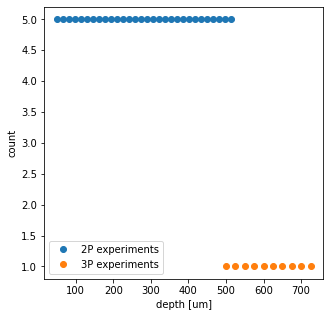

In [4]:
unique_depth_2p, count_2p = np.unique(
    exp_depths[exp_depths['type'] == 2]['depth'].to_numpy(), return_counts=True)
unique_depth_3p, count_3p = np.unique(
    exp_depths[exp_depths['type'] == 3]['depth'].to_numpy(), return_counts=True)
plt.figure(figsize=(5, 5))
plt.xlabel("depth [um]")
plt.ylabel("count")
plt.plot(unique_depth_2p, count_2p, 'o', label='2P experiments')
plt.plot(unique_depth_3p, count_3p, 'o', label='3P experiments')
plt.legend(loc=0)

Find the unique values of depth across experiments.

In [5]:
unique_depths = np.unique(exp_depths['depth'])

Randomly sub sample experiements without replacement from each unique depth with equal probablity.

In [6]:
# Seed with the first experiment's id.
rng = np.random.default_rng(exp_depths['exp_id'][0])
# List to store selected experiments.
selected_exp_ids = []
n_samples = 80
while len(selected_exp_ids) < n_samples:
    # Randomly select a unique depth.
    depth_bin = unique_depths[rng.integers(0, len(unique_depths))]
    # Find all experiments that have this unique depth.
    sub_exp_ids = exp_depths['exp_id'][exp_depths['depth'] == depth_bin].to_numpy()
    # Randomly grab an experiment id from the list of ids with this depth.
    exp_id = sub_exp_ids[rng.integers(0, len(sub_exp_ids))]
    # If we have already selected this experiment, discard this draw and continue.
    if exp_id in selected_exp_ids:
        continue
    # Append the selected id.
    selected_exp_ids.append(exp_id)

In [7]:
np.sort(selected_exp_ids)

array([774392903, 774392931, 774392958, 774393041, 783605202, 783605213,
       783605225, 783605236, 783605259, 783623253, 783623286, 784370396,
       784370407, 784370431, 784388288, 784388321, 784388343, 785569423,
       785569436, 785569447, 785569459, 786334337, 786334350, 786334394,
       786400863, 786400874, 786400885, 787473465, 787473478, 787473500,
       787473512, 788422836, 788422870, 790118127, 790122271, 790122293,
       790122304, 790623924, 790623944, 790624009, 790624031, 790986879,
       790986890, 791920168, 791920202, 792757238, 792757272, 792757295,
       792765535, 792765546, 792765582, 793618831, 793618875, 794123773,
       794123785, 794288307, 794288320, 794288331, 794288342, 794288353,
       794298187, 794298198, 794298220, 795011974, 795012030, 795018546,
       795018557, 795018579, 795897800, 795901861, 795901873, 803616717,
       803958257, 803959659, 803965468, 806844147, 806847865, 806854201,
       806856553, 806928824])

Check to see how many of the problematic experiments there are in this sample. There are 10 so in the full sample the fraction is 0.0625.

In [8]:
problematic_exp_ids = [774393041, 783605247, 783605259, 784388321, 784388332,
                       784388343, 785569470, 794298198, 794298209, 794298220]
np.isin(problematic_exp_ids, selected_exp_ids).sum() / n_samples

0.075

Check to see how many of the 3P experiments there are in this sample. There are 10 so in the full sample the fraction is 0.0625.

In [9]:
np.isin(exp_depths['exp_id'][exp_depths['type'] == 3].to_numpy(),
        selected_exp_ids).sum() / n_samples

0.1125

Randomly pick a set of regions for each experiment. Create a dictionary to write to json.

In [10]:
output_dict = {}
rng = np.random.default_rng(1234)
for exp_id in selected_exp_ids:
    output_dict[int(exp_id)] = {"regions": np.sort(rng.permutation(np.arange(0, 9))[:3]).tolist()}

Write experiment id, region samples to disk.

In [11]:
with open('/allen/aibs/informatics/chris.morrison/ticket-29/cell_app_sample.json', 'w') as jfile:
    json.dump(output_dict, jfile, indent=2)